## Predicting Credit Card Approvals 


### 1. Project Overview
<p>Commercial banks receive <em>a lot</em> of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this project, I will build an automatic credit card approval predictor using machine learning techniques, just like the real banks do. I will use <strong>logistic regression</strong> and <strong>random forest</strong> since they are quite flexibile and interpretable.</p>

<!--<p>The structure of this notebook is as follows:</p>
<ol>
<li>Data Preperation</li>
<li>Model Training</li>
<li>We will have to preprocess the dataset to ensure the machine learning model we choose can make good predictions.</li>
<li>After our data is in good shape, we will do some exploratory data analysis to build our intuitions.</li>
<li>Finally, we will build a machine learning model that can predict if an individual's application for a credit card will be accepted.</li>
</ol>-->

### 2. Data

<p>
    The dataset used in this project is the <a href="http://archive.ics.uci.edu/ml/datasets/credit+approval">Credit Card Approval dataset</a> from the UCI Machine Learning Repository. Note that according to the data source:
    <ol> 
        <li> "All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data". This won't affect the models' prediction accuracy but wiil affect our ability to interpret the models in relation to real world factors, since they are anonymous.</li>
        <li> There are missing values and out of all 16 attributes, 6 are numeric and 10 including the dependent variable are catogorical.</li>
    </ol>
<p>

### 3. Importing And Exploring Data

First, we import the data, followed by some simple data explorations. Exploring data gives us a basic understanding of the data. It can help us identify neccessary processing before fitting a model. In this step, we can see the following issues:
<ol>
    <li>Per the data source, column 1(the 2nd attribute) should be numeric, but our inspection shows that it is a string type(in Python, the data type of a string is <code>'object'</code>). We will need to convert this column into a numeric one.</li>
    <li>Per the data source, column 13 should be catogorical instead of continuouse. Looking at the values in this column, we can easily figure this is the zip code. It's reasonable to assume zip code doesn't have significant influence in predicting credit card approval and so I will drop column 13.</li>
    <li>Rejected and accepted applications are 383 and 307 respectively.
</ol>



 <!--In the following, by exploring the data, we find that attribute 1(column 1) is an object type(in Python, a string is an <code>'object'</code> type) but it obviously is an categorical attribute but a numeric one. This is a single that missing values are represented by an <code>'object'</code> type, in others words a character or a string. When a column has both numbers and characters, <code>pandas</code> automatically turns the column into an object type column. We will handle this problem later. Attribute 13 appears to have the same problem but in fact, it's obvious that it is the zip code attribute. If it is converted into integers, a value like '00202' will become 202 and python will treat it as if it's a number. This is not what we want so we will leave attribute 13 as a categorical column as it is.-->

### 3. Data Preprocessing


#### Importing data

In [1]:
import numpy as np
import pandas as pd

# create column names according to data source: "A1" - "A16"
col_names = ["A"+ str(_) for _ in range(16)]

# Load dataset
cc_apps = pd.read_csv('datasets/crx.data', header=None, names=col_names)

# Inspect the first 10 rows
print(cc_apps.head(10))

  A0     A1      A2 A3 A4  A5 A6     A7 A8 A9  A10 A11 A12    A13    A14 A15
0  b  30.83   0.000  u  g   w  v  1.250  t  t    1   f   g  00202      0   +
1  a  58.67   4.460  u  g   q  h  3.040  t  t    6   f   g  00043    560   +
2  a  24.50   0.500  u  g   q  h  1.500  t  f    0   f   g  00280    824   +
3  b  27.83   1.540  u  g   w  v  3.750  t  t    5   t   g  00100      3   +
4  b  20.17   5.625  u  g   w  v  1.710  t  f    0   f   s  00120      0   +
5  b  32.08   4.000  u  g   m  v  2.500  t  f    0   t   g  00360      0   +
6  b  33.17   1.040  u  g   r  h  6.500  t  f    0   t   g  00164  31285   +
7  a  22.92  11.585  u  g  cc  v  0.040  t  f    0   f   g  00080   1349   +
8  b  54.42   0.500  y  p   k  h  3.960  t  f    0   f   g  00180    314   +
9  b  42.50   4.915  y  p   w  v  3.165  t  f    0   t   g  00052   1442   +


#### Inspecting Data

In [2]:
# Print DataFrame information 
cc_apps_info = cc_apps.info()
print(cc_apps_info, '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A0      690 non-null    object 
 1   A1      690 non-null    object 
 2   A2      690 non-null    float64
 3   A3      690 non-null    object 
 4   A4      690 non-null    object 
 5   A5      690 non-null    object 
 6   A6      690 non-null    object 
 7   A7      690 non-null    float64
 8   A8      690 non-null    object 
 9   A9      690 non-null    object 
 10  A10     690 non-null    int64  
 11  A11     690 non-null    object 
 12  A12     690 non-null    object 
 13  A13     690 non-null    object 
 14  A14     690 non-null    int64  
 15  A15     690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB
None 



In [3]:
# Change the labels of the dependent variable from symbols to (1, 0) for statistic convenience
cc_apps['A15'] = [1 if v == '+' else 0 for v in cc_apps['A15']]

In [4]:
# Print summary statistics for each numeric variable
cc_apps_description = cc_apps.describe()
print(cc_apps_description)

               A2          A7        A10            A14         A15
count  690.000000  690.000000  690.00000     690.000000  690.000000
mean     4.758725    2.223406    2.40000    1017.385507    0.444928
std      4.978163    3.346513    4.86294    5210.102598    0.497318
min      0.000000    0.000000    0.00000       0.000000    0.000000
25%      1.000000    0.165000    0.00000       0.000000    0.000000
50%      2.750000    1.000000    0.00000       5.000000    0.000000
75%      7.207500    2.625000    3.00000     395.500000    1.000000
max     28.000000   28.500000   67.00000  100000.000000    1.000000


In [5]:
# Print the number of unique values of each variable
cc_apps.nunique()

A0       3
A1     350
A2     215
A3       4
A4       4
A5      15
A6      10
A7     132
A8       2
A9       2
A10     23
A11      2
A12      3
A13    171
A14    240
A15      2
dtype: int64

In [6]:
# Print the number of rejected and accepted applications
balance = cc_apps['A15'].value_counts().rename({0:'reject',1:'accept'})
print(balance)

reject    383
accept    307
Name: A15, dtype: int64


Note that just looking at the values, we can figure column <code>A13</code> is the zip code attribute. I'll drop this column in this project for the following reasons: 1, it's a fair assumption that zip code doesn't make a significant impact on the approval of a credit card application. 2, it's a categorical attribute with 171 unique values and so removing it will speed up the training process.

In [7]:
# Drop column A13, the zip code attribute
cc_apps = cc_apps.drop(columns='A13')

#### Handling Missing Values

In Python, a missing value is represented by <code>NaN</code>, to handle which variouse built in methods are provided. However, missing values in real-world data could be coded as anything such as "NA", "N/A", "", etc. Turns out missing values in this dataset are coded as <code>'?'</code>, which we will convert into <code>NaN</code>.

There are many ways to deal with missing values. Some common ways include dropping, imputation, interpolation, etc. For simplicity, I will drop entries with missing values. Because I am dropping, I can do it on the whole dataset all together. However, when using any other methods other than dropping, it should be done after spliting the data into training and test sets in order to avoid data leakage. 


<!--Depending on the model, missing values can affect model performance. Even though some models such as tree models are able to handel missing values internally, it's recommended to handle missing values before training model. If the missing values are represented with <code>NaN</code> or <code>None</code>, we can conveniently handle them using the built-in pandas menthods <code>.isna()</code> and <code>.fillna</code>. However, Missing values are not always represented properly in real-world data, meaning other than <code>NaN</code>, they could be anything such as <code>'?'</code>, <code>'N/A'</code>, etc. We need to figure out the representation of missing value here.

The data description that comes this dataset lists the unique values for each attribute. In case  we can find out what they are by comparing the unique values listed in the description with what we actually observe in the dataset. Since this process is verbose, I will reveal that the missing value in this data set is <code>'?'</code>, and for column 13 only, <code>'00000'</code> as well.

In [8]:
# Print the number of missing values in each column
print((cc_apps == '?').sum())

A0     12
A1     12
A2      0
A3      6
A4      6
A5      9
A6      9
A7      0
A8      0
A9      0
A10     0
A11     0
A12     0
A14     0
A15     0
dtype: int64


In [9]:
# Count entries containing '?' 
qm_count = (cc_apps == '?').any(axis=1).sum()
print(f"# of entries containing missing values before dropping: {qm_count}")

# Replace '?' with 'NaN' 
cc_apps = cc_apps.replace('?', np.nan)
cc_apps = cc_apps.dropna()

# Count missing values after dropping
print(f"# of missing values after dropping: {cc_apps.isna().sum().sum()}")


# of entries containing missing values before dropping: 31
# of missing values after dropping: 0


Column <code>A1</code> is an <code>object</code> type(which means values are strings) as shown previousky. Accoring to data source description, it should be a numeric type. <!--This step wasn't done first beause these 2 columns contained the missing value '?', they couldn't be conveniently transformed using built-in methods. Now that '?' are replaced by nan, we could easily do transformation. -->

In [10]:
# Convert column A1 into float type
cc_apps['A1'] = cc_apps['A1'].astype('float64')

print(cc_apps.head(10), '\n')
print(cc_apps.info())

  A0     A1      A2 A3 A4  A5 A6     A7 A8 A9  A10 A11 A12    A14  A15
0  b  30.83   0.000  u  g   w  v  1.250  t  t    1   f   g      0    1
1  a  58.67   4.460  u  g   q  h  3.040  t  t    6   f   g    560    1
2  a  24.50   0.500  u  g   q  h  1.500  t  f    0   f   g    824    1
3  b  27.83   1.540  u  g   w  v  3.750  t  t    5   t   g      3    1
4  b  20.17   5.625  u  g   w  v  1.710  t  f    0   f   s      0    1
5  b  32.08   4.000  u  g   m  v  2.500  t  f    0   t   g      0    1
6  b  33.17   1.040  u  g   r  h  6.500  t  f    0   t   g  31285    1
7  a  22.92  11.585  u  g  cc  v  0.040  t  f    0   f   g   1349    1
8  b  54.42   0.500  y  p   k  h  3.960  t  f    0   f   g    314    1
9  b  42.50   4.915  y  p   w  v  3.165  t  f    0   t   g   1442    1 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659 entries, 0 to 689
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A0      659 non-null    object 
 

### Repeated K-fold Cross Validation

It's a robust proceduce to get a better estimate of genral error of a model sepecially when data is not abundant. 

#### Pipeline
Sklearn's pipeline package allows essembly of multiple processes into one big process. All steps below will be essembled in a Pipeline object which will be fiited with train data and transform test data in every split during the repeated k-fold cross validation process.

* **Handling Catogorical Variables**\
Categorical varibles have to transform into dummy variabels in order for many machine learning models to work. 

* **Feature Scaling**\
Varibles having differents scales can create bias. Although not neccessary for all models, scaling can reduce the training/optimization time and increase interpretability for many models. Here we will use min max scaler to scale the data to the range between 0 to 1. 

In [11]:
# define x as indepentent varible and y as dependent variabel
X = cc_apps.loc[:,:'A14']
y = cc_apps['A15']

In [12]:
def estimator_name(esmtr, local_items):
    '''Get the variable name of an estimator by searching throught all local items. A helper function

    Args
    ____
    esmtr: An estimator, i.e., LinearRegression()
    local_items: A dictornary of all variabel items produced by local.items() in the local scale
                where the estimators are
    '''
    for p, q in local_items:
        # if match the estimator 
        if ((p !='esmtr') and (q is esmtr)):
            return p

In [13]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from numbers import Number
from tempfile import mkdtemp
from sklearn.pipeline import Pipeline

# ColumnTransformer allows one-hot-encoding to cat variabels and min-max-scaling to numeric variables
num_cols = X.select_dtypes(include=np.number).columns.to_list()
cat_cols = X.select_dtypes(include=object).columns.to_list()
ohe_and_mmc = ColumnTransformer([('ohe',  OneHotEncoder(handle_unknown='ignore'), cat_cols),('mms', MinMaxScaler(), num_cols)]) 

# using AUC score as performamce measurement
scorers = ['roc_auc', 'accuracy']

# initiate an RepeatedStratifiedKFold instance
n_repeats = 50
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=n_repeats,
    random_state=888888)

# initiate logitic regression and random forest classifiers
lg = LogisticRegression()
rf = RandomForestClassifier()

esmtrs = [lg, rf]
names=[]
rkfcv_results = {}
local_items = locals().items()

# fit each estimator and store results 
for i, esmtr in enumerate(esmtrs):
    # automate the naming process required by the Pipeline object
    names.append(estimator_name(esmtr, local_items))
    steps = [('ohe_and_mmc',ohe_and_mmc), (names[i], esmtr)]
    cachedir = mkdtemp()
    pipe = Pipeline(steps, memory=cachedir)
    cv_results = cross_validate(pipe, X, y, cv=rskf, return_train_score=True, return_estimator=True, scoring=scorers, error_score='raise')   
    rkfcv_results[names[i]] = cv_results 

#### Model Assessment

I am using ROC AUC as the scoring method. It does a better job estimating general error than accuracy with imbalanced datasets. 

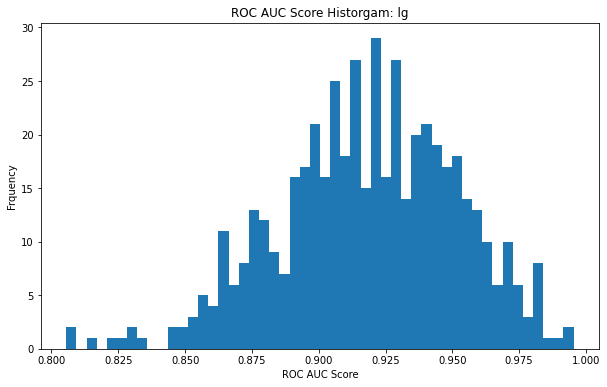

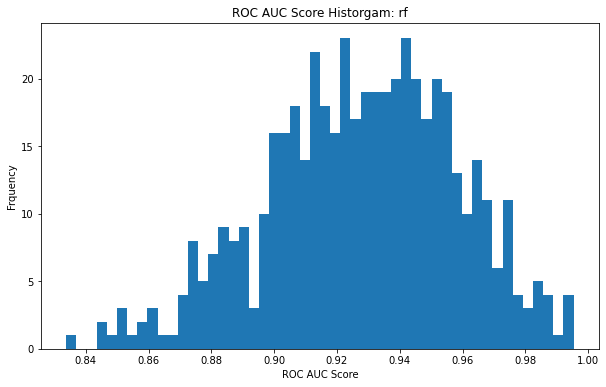

In [14]:
import matplotlib.pyplot as plt

# create a dictionary to store the best performing split for demonstration/visualization
best_split = {}

# create a dictionary to store the means 
metric_means = {}

for k, v in rkfcv_results.items():

    # create a dicitonary for each model(lg, rf, etc.) 
    best_split[k] = {}

    # create a dictionary for each model 
    metric_means[k] = {}

    # get index of the split with best roc auc performance
    best_split_idx = np.argmax(v['test_roc_auc'])
    best_split[k]['index'] = best_split_idx

    for name, metric in v.items():
            best_split[k][name]= metric[best_split_idx]
            if name != 'estimator':   
                metric_means[k][name] = np.mean(metric)
    


for esmtr in names:
    
    plt.figure(figsize=(10,6))
    plt.hist(rkfcv_results[esmtr]['test_roc_auc'], bins=n_repeats)
    plt.title('ROC AUC Score Historgam: '+ esmtr)
    plt.ylabel('Frquency')
    plt.xlabel('ROC AUC Score')
    plt.show()



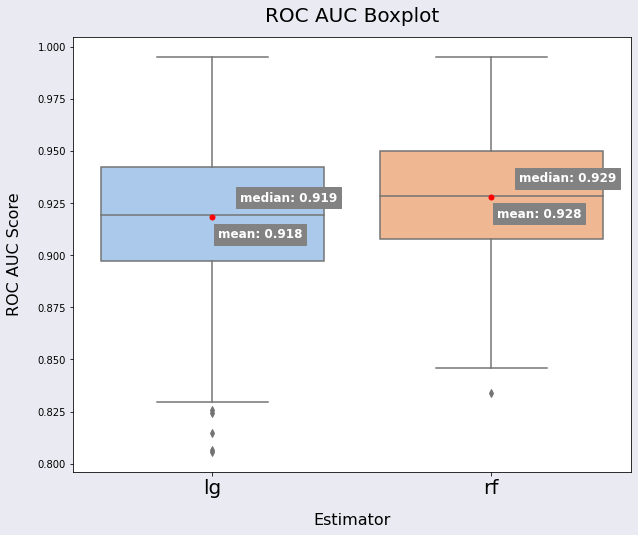

In [15]:

import seaborn as sns
facecolor = '#eaeaf2'

fig, ax = plt.subplots(figsize=(10,8),facecolor=facecolor)
sns.boxplot(data=[rkfcv_results[names[0]]['test_roc_auc'],rkfcv_results[names[1]]['test_roc_auc']],
                showmeans=True,meanprops={"marker": ".",
                       "markeredgecolor": "red",
                       "markerfacecolor": "red",
                       "markersize": "10"},
                       ax=ax, palette='pastel')
ax.set_xticks(range(len(names)),labels=names,fontsize=20)
plt.ylabel('ROC AUC Score', fontsize=16, labelpad=15)
plt.xlabel('Estimator', fontsize=16, labelpad=15)
plt.title('ROC AUC Boxplot', fontsize=20, pad=15)


# for i, box in enumerate(ax.artists):
#         print(i)
#         col = box.get_facecolor()
#         plt.setp(ax.lines[i*6+5], mfc=col, mec=col)


# Get line information
lines = ax.get_lines()
# x_pos is the same the 
x_ticks = ax.get_xticks()

# every 4th line at the interval of 6 is the median line when showmeans = False;
# when showmeans = True, mean is every 5th line at the interval of 7,
# (0 = 25th percentile, 1 = 75th percentile, 2 = lower whisker, 
# 3 = upper whisker, 4 = 50th percentile, and 5 = mean, 6 = upper extreme value)

for x_pos in x_ticks:
    # y_pos is the same as the mean 
    y_pos = lines[5+x_pos*7].get_ydata()[0]

    # Annotate the mean on the graph
    ax.text(
        x_pos+0.02, 
        y_pos-0.005, 
        f'mean: {y_pos:.3f}',
        ha='left', 
        va='top', 
        fontweight='semibold', 
        size=12,
        color='white',
        bbox=dict(facecolor='#828282', edgecolor='#828282')
    )

    # y_pos is the median
    y_pos = lines[4+x_pos*7].get_ydata()[0]

    # Annotate the median on the graph
    ax.text(
        x_pos+0.1, 
        y_pos+0.005, 
        f'median: {y_pos:.3f}',
        ha='left', 
        va='bottom', 
        fontweight='semibold', 
        size=12,
        color='white',
        bbox=dict(facecolor='#828282', edgecolor='#828282')
    )
filename = 'figures/boxplot.png'
plt.savefig(filename, facecolor=facecolor)


In [16]:
best_split['rf']['test_roc_auc']

0.9953703703703703

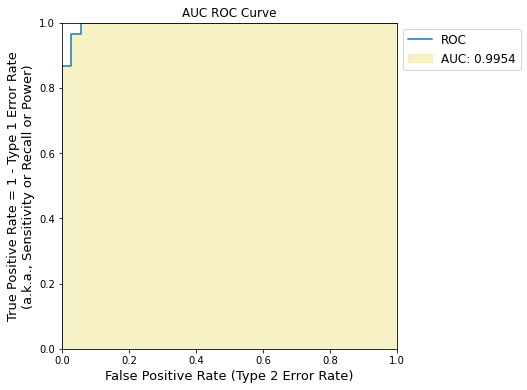

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

train_idx, test_idx = list(rskf.split(X,y))[best_split_idx]
X_test_py, y_test_py = X.iloc[test_idx], y.iloc[test_idx]

# draw ROC AUC graph for the best split
y_pred_prob = best_split['rf']['estimator'].predict_proba(X_test_py)

# get fpr, tpr and threshold
auc = roc_auc_score(y_test_py, y_pred_prob[:,1])
fpr, tpr, threshold = roc_curve(y_test_py, y_pred_prob[:,1])


plt.figure(figsize=(6,6))
# ROC line
plt.plot(fpr,tpr, label='ROC')
# AUC area
plt.fill_between(fpr, tpr, color='khaki', alpha=0.5, label=f'AUC: {auc:.4f}')
# Threshold
# plt.plot(np.arange(0.0, 1.1, 0.1), np.arange(0.0, 1.1, 0.1), linestyle='--', label='Threshold Line')
# Threshold = 0.5 intercept
# plt.plot(np.arange(0.0, 0.6, 0.1), np.arange(1, 0.4, -0.1), color='green', linestyle=':', label='Threshold=0.5')


plt.legend(loc='upper left', fontsize='large', bbox_to_anchor=(1, 1))
plt.xlabel('False Positive Rate (Type 2 Error Rate)', size=13)
plt.ylabel('True Positive Rate = 1 - Type 1 Error Rate\n(a.k.a., Sensitivity or Recall or Power)',size=13)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(f'AUC ROC Curve');


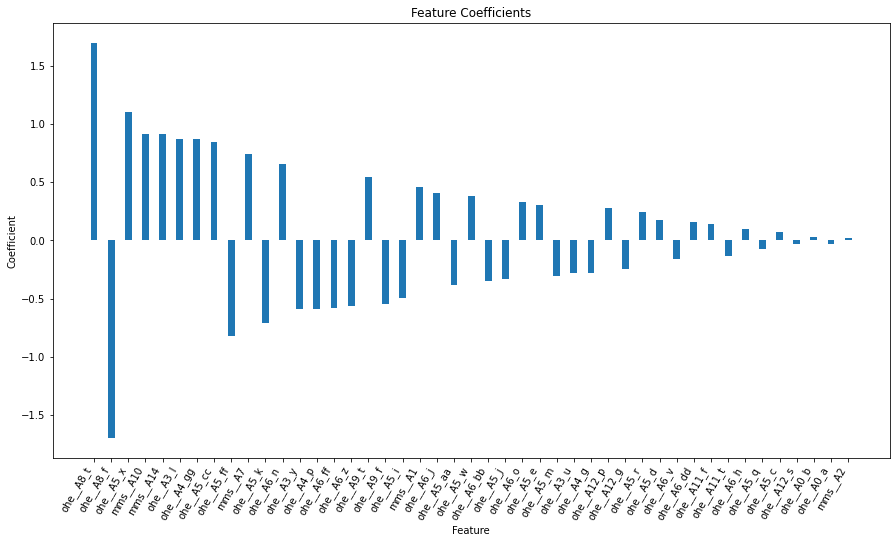

In [19]:
import matplotlib.pyplot as plt
# show feature importance/coeeficient of the model
columns_bm = best_split['lg']['estimator'].named_steps['ohe_and_mmc'].get_feature_names_out()
importance = best_split['lg']['estimator'].named_steps['lg'].coef_[0]
ser_importance = pd.Series(importance,index=columns_bm).sort_values(ascending=False,key=abs)
# plot importance of features
x = [2*i for i in range(len(importance))]
x_py = [i+0.3 for i in x]
fig, ax = plt.subplots(figsize=(15,8),facecolor='white')
plt.bar(x, ser_importance.values)
plt.title('Feature Coefficients')
plt.xticks(x, ser_importance.index,rotation=60, ha='right')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.show()
#plt.tight_layout()

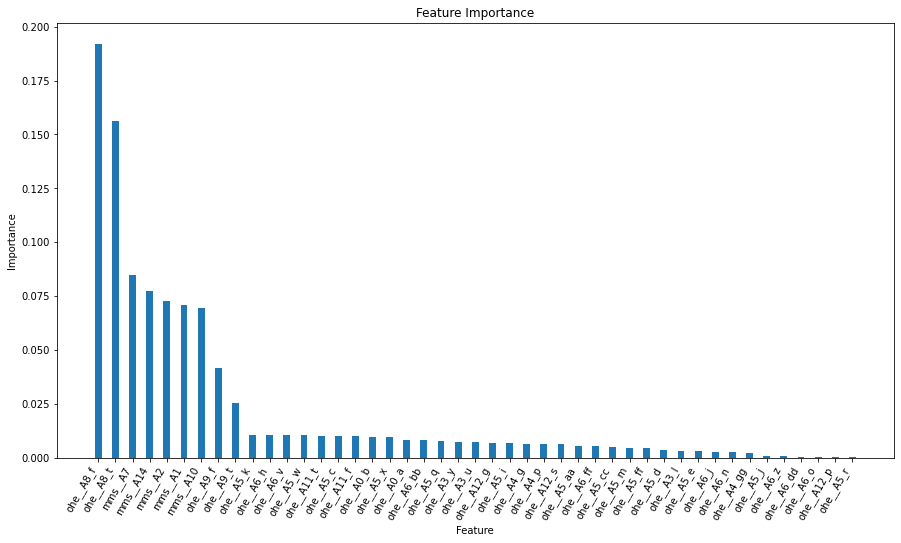

In [20]:
# show feature importance/coeeficient of the model
columns_bm = best_split['rf']['estimator'].named_steps['ohe_and_mmc'].get_feature_names_out()
importance = best_split['rf']['estimator'].named_steps['rf'].feature_importances_
ser_importance = pd.Series(importance,index=columns_bm).sort_values(ascending=False)
# plot importance of features
x = [2*i for i in range(len(importance))]
x_py = [i+0.3 for i in x]
fig, ax = plt.subplots(figsize=(15,8),facecolor='white')
plt.bar(x, ser_importance.values)
plt.title('Feature Importance')
plt.xticks(x, ser_importance.index,rotation=60, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()